### 1. import modules

In [40]:
import os
import tqdm
import argparse
import numpy as np

import torch
from torchvision.utils import save_image

from model import WaveEncoder, WaveDecoder

from utils.core import feature_wct
from utils.io import Timer, open_image, load_segment, compute_label_info


class WCT2:
    def __init__(self, model_path='./model_checkpoints', transfer_at=['encoder', 'skip', 'decoder'], option_unpool='cat5', device='cuda:0', verbose=False):

        self.transfer_at = set(transfer_at)
        assert not(self.transfer_at - set(['encoder', 'decoder', 'skip'])), 'invalid transfer_at: {}'.format(transfer_at)
        assert self.transfer_at, 'empty transfer_at'

        self.device = torch.device(device)
        self.verbose = verbose
        self.encoder = WaveEncoder(option_unpool).to(self.device)
        self.decoder = WaveDecoder(option_unpool).to(self.device)
        self.encoder.load_state_dict(torch.load(os.path.join(model_path, 'wave_encoder_{}_l4.pth'.format(option_unpool)), map_location=self.device))
        self.decoder.load_state_dict(torch.load(os.path.join(model_path, 'wave_decoder_{}_l4.pth'.format(option_unpool)), map_location=self.device))

    def print_(self, msg):
        if self.verbose:
            print(msg)

    def encode(self, x, skips, level):
        return self.encoder.encode(x, skips, level)

    def decode(self, x, skips, level):
        return self.decoder.decode(x, skips, level)

    def get_all_feature(self, x):
        skips = {}
        feats = {'encoder': {}, 'decoder': {}}
        for level in [1, 2, 3, 4]:
            x = self.encode(x, skips, level)
            if 'encoder' in self.transfer_at:
                feats['encoder'][level] = x

        if 'encoder' not in self.transfer_at:
            feats['decoder'][4] = x
        for level in [4, 3, 2]:
            x = self.decode(x, skips, level)
            if 'decoder' in self.transfer_at:
                feats['decoder'][level - 1] = x
        return feats, skips

    def transfer(self, content, style, content_segment, style_segment, alpha=1):
        label_set, label_indicator = compute_label_info(content_segment, style_segment)
        content_feat, content_skips = content, {}
        style_feats, style_skips = self.get_all_feature(style)

        wct2_enc_level = [1, 2, 3, 4]
        wct2_dec_level = [1, 2, 3, 4]
        wct2_skip_level = ['pool1', 'pool2', 'pool3']

        for level in [1, 2, 3, 4]:
            content_feat = self.encode(content_feat, content_skips, level)
            if 'encoder' in self.transfer_at and level in wct2_enc_level:
                content_feat = feature_wct(content_feat, style_feats['encoder'][level],
                                           content_segment, style_segment,
                                           label_set, label_indicator,
                                           alpha=alpha, device=self.device)
                self.print_('transfer at encoder {}'.format(level))
        if 'skip' in self.transfer_at:
            for skip_level in wct2_skip_level:
                for component in [0, 1, 2]:  # component: [LH, HL, HH]
                    content_skips[skip_level][component] = feature_wct(content_skips[skip_level][component], style_skips[skip_level][component],
                                                                       content_segment, style_segment,
                                                                       label_set, label_indicator,
                                                                       alpha=alpha, device=self.device)
                self.print_('transfer at skip {}'.format(skip_level))

        for level in [4, 3, 2, 1]:
            if 'decoder' in self.transfer_at and level in style_feats['decoder'] and level in wct2_dec_level:
                content_feat = feature_wct(content_feat, style_feats['decoder'][level],
                                           content_segment, style_segment,
                                           label_set, label_indicator,
                                           alpha=alpha, device=self.device)
                self.print_('transfer at decoder {}'.format(level))
            content_feat = self.decode(content_feat, content_skips, level)
        return content_feat


def get_all_transfer():
    ret = []
    for e in ['encoder', None]:
        for d in ['decoder', None]:
            for s in ['skip', None]:
                _ret = set([e, d, s]) & set(['encoder', 'decoder', 'skip'])
                if _ret:
                    ret.append(_ret)
    return ret


def run_bulk(config):
    device = 'cpu' if config.cpu or not torch.cuda.is_available() else 'cuda:0'
    device = torch.device(device)

    transfer_at = set()
    if config.transfer_at_encoder:
        transfer_at.add('encoder')
    if config.transfer_at_decoder:
        transfer_at.add('decoder')
    if config.transfer_at_skip:
        transfer_at.add('skip')

    # The filenames of the content and style pair should match
    fnames = set(os.listdir(config.content)) & set(os.listdir(config.style))

    if config.content_segment and config.style_segment:
        fnames &= set(os.listdir(config.content_segment))
        fnames &= set(os.listdir(config.style_segment))

    for fname in tqdm.tqdm(fnames):
        try:
            if not fname.endswith('.png'):
                print('invalid file (should end with .png), ', fname)
                continue
            _content = os.path.join(config.content, fname)
            _style = os.path.join(config.style, fname)
            _content_segment = os.path.join(config.content_segment, fname) if config.content_segment else None
            _style_segment = os.path.join(config.style_segment, fname) if config.style_segment else None
            _output = os.path.join(config.output, fname)

            content = open_image(_content, config.image_size).to(device)
            style = open_image(_style, config.image_size).to(device)
            content_segment = load_segment(_content_segment, config.image_size)
            style_segment = load_segment(_style_segment, config.image_size)

            if not config.transfer_all:
                with Timer('Elapsed time in whole WCT: {}', config.verbose):
                    postfix = '_'.join(sorted(list(transfer_at)))
                    fname_output = _output.replace('.png', '_{}_{}.png'.format(config.option_unpool, postfix))
                    print('------ transfer:', _output)
                    wct2 = WCT2(transfer_at=transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)
                    with torch.no_grad():
                        img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)
                    save_image(img.clamp_(0, 1), fname_output, padding=0)
            else:
                for _transfer_at in get_all_transfer():
                    with Timer('Elapsed time in whole WCT: {}', config.verbose):
                        postfix = '_'.join(sorted(list(_transfer_at)))
                        fname_output = _output.replace('.png', '_{}_{}.png'.format(config.option_unpool, postfix))
                        print('------ transfer:', fname)
                        wct2 = WCT2(transfer_at=_transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)
                        with torch.no_grad():
                            img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)
                        save_image(img.clamp_(0, 1), fname_output, padding=0)
        except:
            continue


In [78]:
class argparse(dict):
    """
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(argparse, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.iteritems():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.iteritems():
                self[k] = v
    def add_argument(self, *args, **kwargs):
        # super(Map, self).__init__(*args, **kwargs)
        for i in args:
            self[i.strip('-')] = kwargs.get('default', None)
            if 'action' in kwargs:
                if kwargs['action'] == 'store_true':
                    self[i.strip('-')] = True
                else:
                    self[i.strip('-')] = False
    def parse_args(self):
        return self

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(argparse, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(argparse, self).__delitem__(key)
        del self.__dict__[key]

In [79]:
parser = argparse()
parser.add_argument('--content', type=str, default='./examples/content1')
parser.add_argument('--content_segment', type=str, default='./examples/content_segment')
parser.add_argument('--style', type=str, default='./examples/style')
parser.add_argument('--style_segment', type=str, default='./examples/style_segment')
parser.add_argument('--output', type=str, default='./outputs')
parser.add_argument('--image_size', type=int, default=512)
parser.add_argument('--alpha', type=float, default=1)
parser.add_argument('--option_unpool', type=str, default='cat5', choices=['sum', 'cat5'])
parser.add_argument('-e', '--transfer_at_encoder', action='store_true')
parser.add_argument('-d', '--transfer_at_decoder', action='store_true')
parser.add_argument('-s', '--transfer_at_skip', action='store_true')
parser.add_argument('-a', '--transfer_all', action='store_true')
parser.add_argument('--cpu', action='store_true')
parser.add_argument('--verbose', action='store_true')


In [80]:
config = parser.parse_args()


In [81]:

print(config)

# if not os.path.exists(os.path.join(config.output)):
#     os.makedirs(os.path.join(config.output))

'''
CUDA_VISIBLE_DEVICES=6 python transfer.py --content ./examples/content --style ./examples/style --content_segment ./examples/content_segment --style_segment ./examples/style_segment/ --output ./outputs/ --verbose --image_size 512 -a
'''
# run_bulk(config)


{'content': './examples/content1', 'content_segment': './examples/content_segment', 'style': './examples/style', 'style_segment': './examples/style_segment', 'output': './outputs', 'image_size': 512, 'alpha': 1, 'option_unpool': 'cat5', 'e': True, 'transfer_at_encoder': True, 'd': True, 'transfer_at_decoder': True, 's': True, 'transfer_at_skip': True, 'a': True, 'transfer_all': True, 'cpu': True, 'verbose': True}


'\nCUDA_VISIBLE_DEVICES=6 python transfer.py --content ./examples/content --style ./examples/style --content_segment ./examples/content_segment --style_segment ./examples/style_segment/ --output ./outputs/ --verbose --image_size 512 -a\n'

In [82]:
device = 'cuda:0'
device = torch.device(device)

transfer_at = set()
# The filenames of the content and style pair should match
fnames = set(os.listdir(config.content)) & set(os.listdir(config.style))

if config.content_segment and config.style_segment:
    fnames &= set(os.listdir(config.content_segment))
    fnames &= set(os.listdir(config.style_segment))


In [83]:
fnames

{'gym1.jpg', 'train1.jpg', 'train2.jpg', 'train3.jpg'}

In [12]:
fname = '鞍馬寺.png'

In [115]:
fname = 'gym1.jpg'

In [116]:
_content = os.path.join(config.content, fname)
_style = os.path.join(config.style, fname)
_content_segment = os.path.join(config.content_segment, fname) if config.content_segment else None
_style_segment = os.path.join(config.style_segment, fname) if config.style_segment else None
_output = os.path.join(config.output, fname)

In [117]:
content = open_image(_content, config.image_size).to(device)
style = open_image(_style, config.image_size).to(device)
content_segment = load_segment(_content_segment, config.image_size)
style_segment = load_segment(_style_segment, config.image_size)

In [118]:
content = open_image(_content).to(device)
content.shape

torch.Size([1, 3, 256, 400])

In [119]:
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image


In [120]:
image = Image.open(_content)

In [121]:
_transforms = []
w, h = image.size

In [122]:
w,h

(412, 270)

In [123]:
_transforms.append(transforms.CenterCrop((h // 16 * 16, w // 16 * 16)))

In [124]:
_transforms

[CenterCrop(size=(256, 400))]

In [125]:
_transforms.append(transforms.ToTensor())
_transforms

[CenterCrop(size=(256, 400)), ToTensor()]

In [126]:
transform = transforms.Compose(_transforms)
transform

Compose(
    CenterCrop(size=(256, 400))
    ToTensor()
)

In [127]:
result = transform(image).unsqueeze(0)
result.shape

torch.Size([1, 3, 256, 400])

In [128]:
transform(image)[:3].unsqueeze(0).shape

torch.Size([1, 3, 256, 400])

In [129]:
content.shape

torch.Size([1, 3, 256, 400])

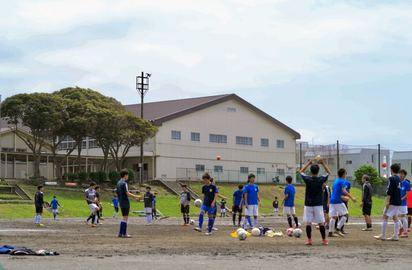

In [130]:
from IPython.display import Image
Image(filename=_content) 

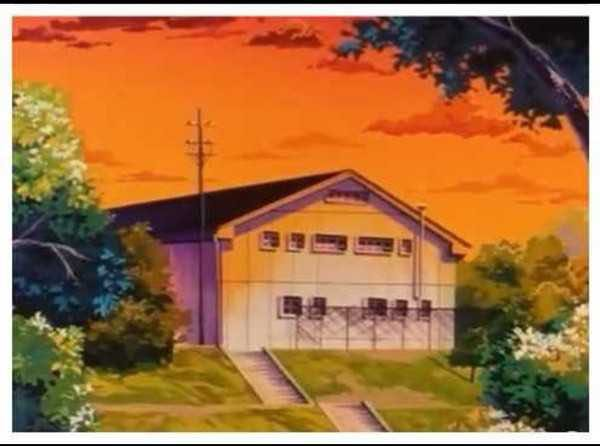

In [131]:
Image(filename=_style) 

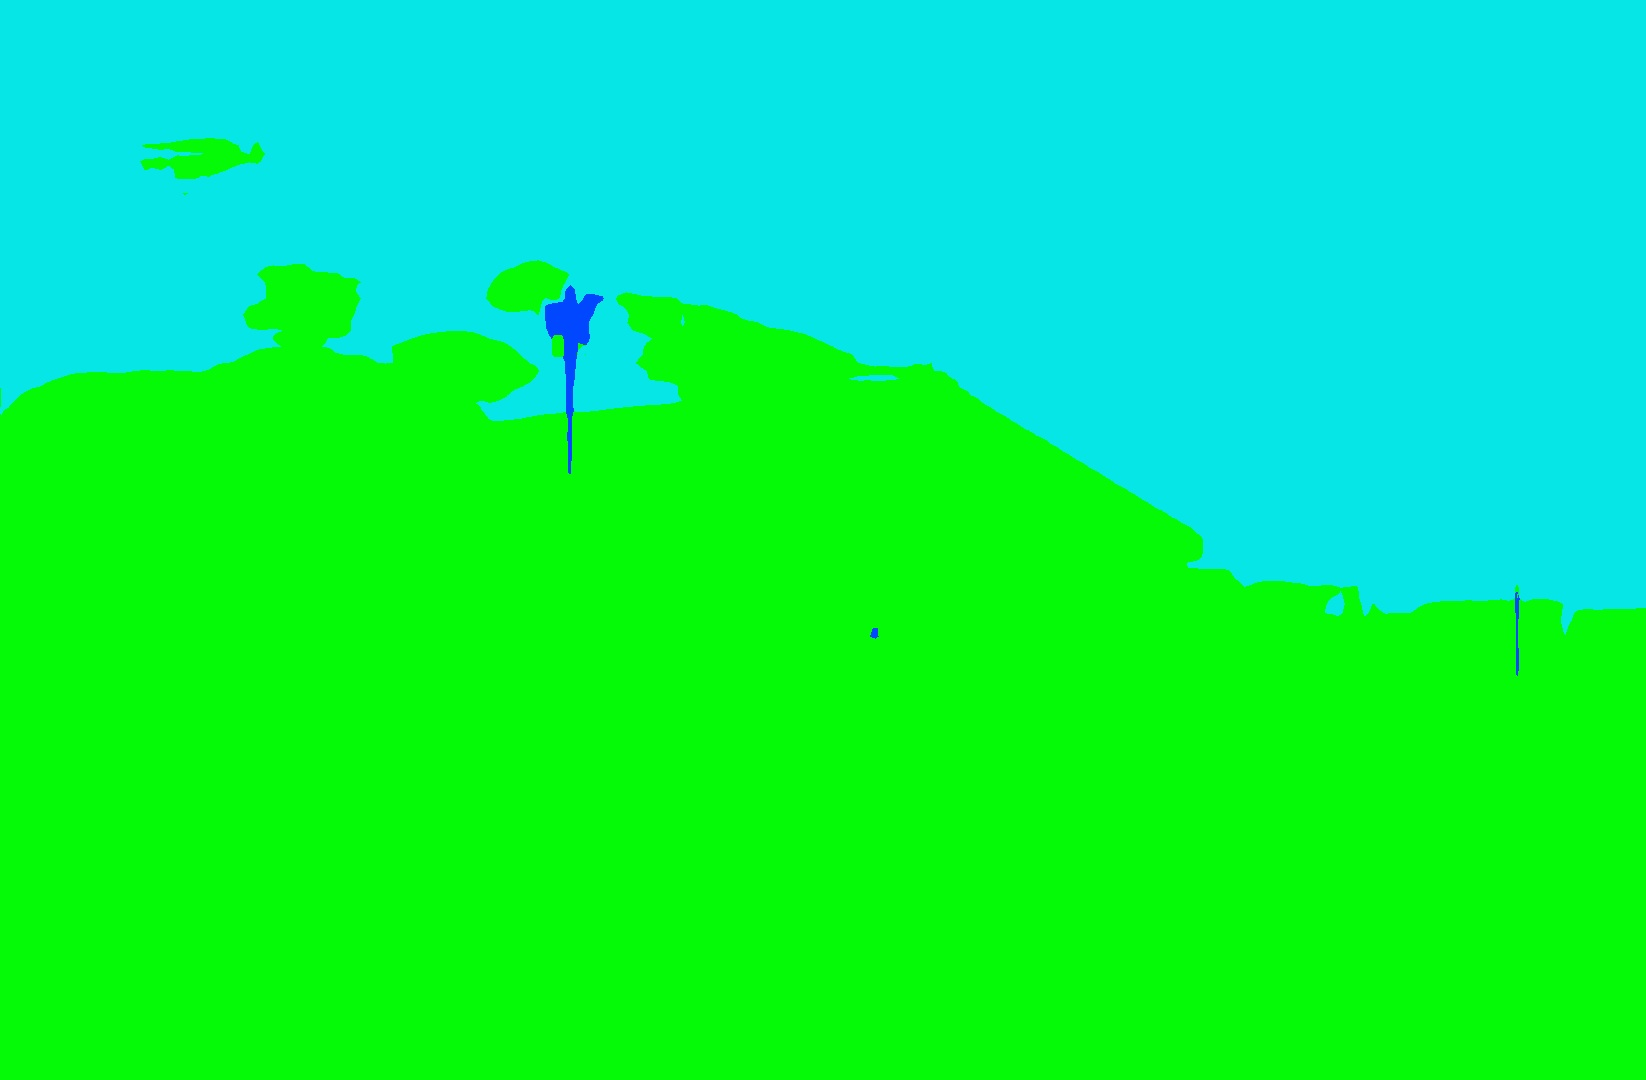

In [132]:
Image(filename=_content_segment) 

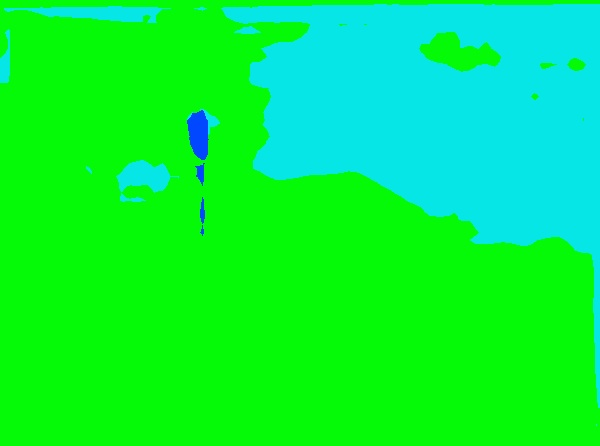

In [133]:
Image(filename=_style_segment) 

In [134]:
get_all_transfer()

[{'decoder', 'encoder', 'skip'},
 {'decoder', 'encoder'},
 {'encoder', 'skip'},
 {'encoder'},
 {'decoder', 'skip'},
 {'decoder'},
 {'skip'}]

In [135]:
postfix = '_'.join(sorted(list(_transfer_at)))
postfix

'decoder_encoder_skip'

In [136]:
fname_output = _output.replace('.png', '_{}_{}.png'.format(config.option_unpool, postfix))
fname_output

'./outputs/gym1.jpg'

In [137]:
wct2 = WCT2(transfer_at=_transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)

In [138]:
content = open_image(_content).to(device)
content.shape

torch.Size([1, 3, 256, 400])

In [139]:
style.shape

torch.Size([1, 3, 512, 688])

In [140]:
content.shape

torch.Size([1, 3, 256, 400])

In [141]:
content_segment.shape

(512, 768)

In [142]:
with torch.no_grad():
    img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)


transfer at encoder 1
transfer at encoder 2
transfer at encoder 3
transfer at encoder 4
transfer at skip pool1
transfer at skip pool2
transfer at skip pool3
transfer at decoder 3
transfer at decoder 2
transfer at decoder 1


In [146]:
for _transfer_at in get_all_transfer():
    with Timer('Elapsed time in whole WCT: {}', config.verbose):
        postfix = '_'.join(sorted(list(_transfer_at)))
        fname_output = _output.replace('.jpg', '_{}_{}.png'.format(config.option_unpool, postfix))
        print('------ transfer:', fname)
        wct2 = WCT2(transfer_at=_transfer_at, option_unpool=config.option_unpool, device=device, verbose=config.verbose)
        with torch.no_grad():
            img = wct2.transfer(content, style, content_segment, style_segment, alpha=config.alpha)
        save_image(img.clamp_(0, 1), fname_output, padding=0)


------ transfer: gym1.jpg
transfer at encoder 1
transfer at encoder 2
transfer at encoder 3
transfer at encoder 4
transfer at skip pool1
transfer at skip pool2
transfer at skip pool3
transfer at decoder 3
transfer at decoder 2
transfer at decoder 1
Elapsed time in whole WCT: 0:00:02.073381
------ transfer: gym1.jpg
transfer at encoder 1
transfer at encoder 2
transfer at encoder 3
transfer at encoder 4
transfer at decoder 3
transfer at decoder 2
transfer at decoder 1
Elapsed time in whole WCT: 0:00:01.175618
------ transfer: gym1.jpg
transfer at encoder 1
transfer at encoder 2
transfer at encoder 3
transfer at encoder 4
transfer at skip pool1
transfer at skip pool2
transfer at skip pool3
Elapsed time in whole WCT: 0:00:01.692752
------ transfer: gym1.jpg
transfer at encoder 1
transfer at encoder 2
transfer at encoder 3
transfer at encoder 4
Elapsed time in whole WCT: 0:00:00.899947
------ transfer: gym1.jpg
transfer at skip pool1
transfer at skip pool2
transfer at skip pool3
transfer at

In [ ]:
config.transfer_all

In [45]:
content.shape

torch.Size([1, 3, 208, 304])

In [46]:
style.shape

torch.Size([1, 3, 512, 736])

In [47]:
img.shape

torch.Size([1, 3, 208, 304])

In [70]:
fname_output

'./outputs/鞍馬寺_cat5_skip.png'

In [199]:
def cat_images(fname, ls_images_path):
    images = []
    max_width = 0 # find the max width of all the images
    total_height = 0 # the total height of the images (vertical stacking)
    for name in image_names:
        # open all images and find their sizes
        images.append(cv2.imread(name))
        if images[-1].shape[1] > max_width:
            max_width = images[-1].shape[1]
        total_height += images[-1].shape[0]
    
    def cat_arrays(total_height,max_width,arrays):
        # create a new array with a size large enough to contain all the images
        final_array = np.zeros((total_height,max_width,3),dtype=np.uint8)

        current_y = 0 # keep track of where your current image was last placed in the y coordinate
        for array in arrays:
            # add an image to the final array and increment the y coordinate
            final_array[current_y:array.shape[0]+current_y,:array.shape[1],:] = array
            current_y += array.shape[0]
        return final_array
    final_image = cat_arrays(total_height, max_width, images)
    cv2.imwrite(fname,final_image)

image_names = [_content, _style, './outputs/gym1_cat5_encoder_skip.png']
cat_images(fname, image_names)
# Image(fname)

In [200]:
torch.cat((content, style, img), 1)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 256 and 512 in dimension 2 at /opt/conda/conda-bld/pytorch_1550780889552/work/aten/src/THC/generic/THCTensorMath.cu:83